In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import data
import train

## vanderpol datamodule

In [49]:
datamodule = data.ODEDataModule(data.vanderpol, dim, 2, batch_size, 200, 0.1, sigma=0.1)
datamodule.setup("")

In [50]:
_x, _y = next(iter(datamodule.val_dataloader()))
_x = _x.detach().numpy()
_y = _y.detach().numpy()

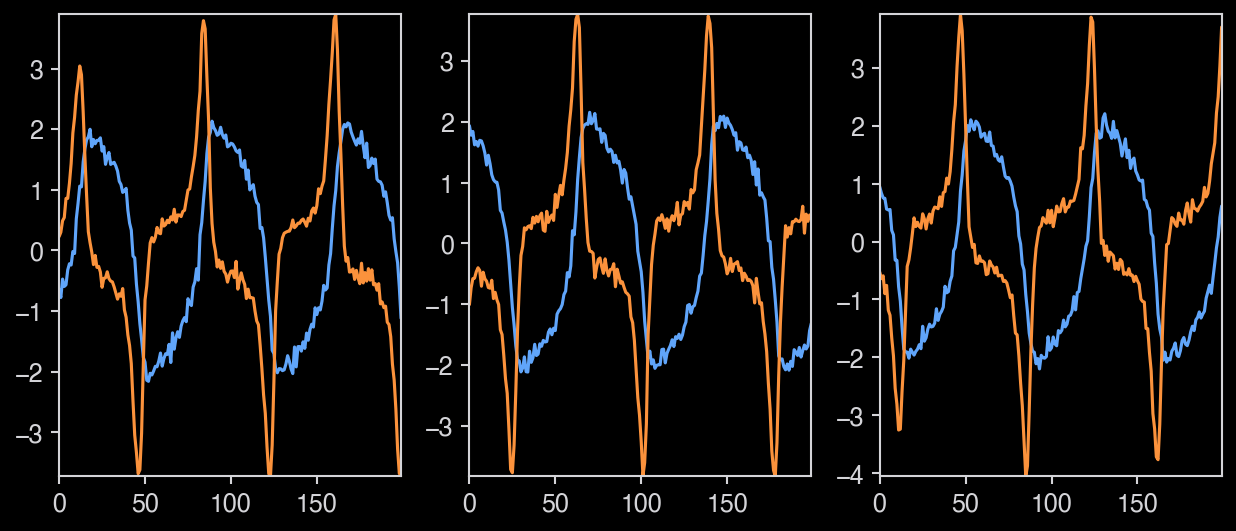

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for k, ax in enumerate(axs):
    ax.plot(_y[k], '-')

## Fit vanderpol dataset

In [52]:
import pytorch_lightning as pl

In [54]:
dim = 2
state_size = 256
batch_size = 32

model = train.RNNDynamics(dim, state_size, wd=1e-3)

trainer = pl.Trainer(accelerator="cpu", max_epochs=10)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/niru/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [55]:
trainer.fit(model, datamodule)

/Users/niru/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/niru/miniconda3/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:377: Found unsupported keys in the optimizer configuration: {'scheduler'}

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | w_in  | Linear | 512    | train
1 | w_out | Linear | 512    | train
2 | gru   | GRU    | 198 K  | train
-----------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.800     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/niru/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of th

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [56]:
import numpy as np
import torch

In [57]:
test_dl = datamodule.test_dataloader()

In [58]:
xs, ys = [], []
for x, y in iter(test_dl):
    xs.append(x)
    ys.append(y)

x = np.vstack(xs)
y = np.vstack(ys)

In [59]:
%%time
states, yhat = model.forward(torch.from_numpy(x).float(), 1000)
states = states.detach().numpy()
yhat = yhat.detach().numpy()

CPU times: user 3.09 s, sys: 769 ms, total: 3.86 s
Wall time: 962 ms


In [60]:
import matplotlib.pyplot as plt
import jetplot as jp

In [61]:
jp.dark_mode()

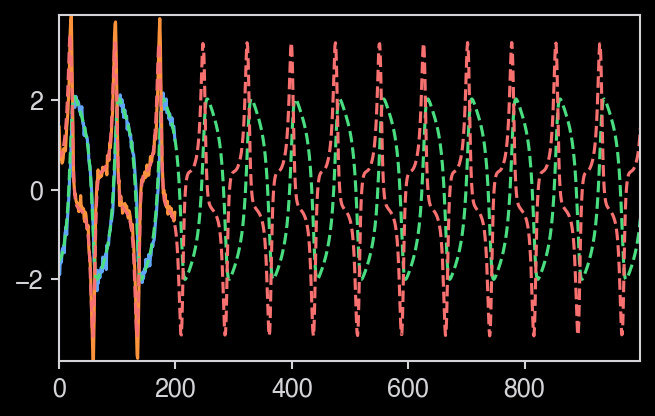

In [63]:
plt.plot(y[0])
plt.plot(yhat[0], '--')

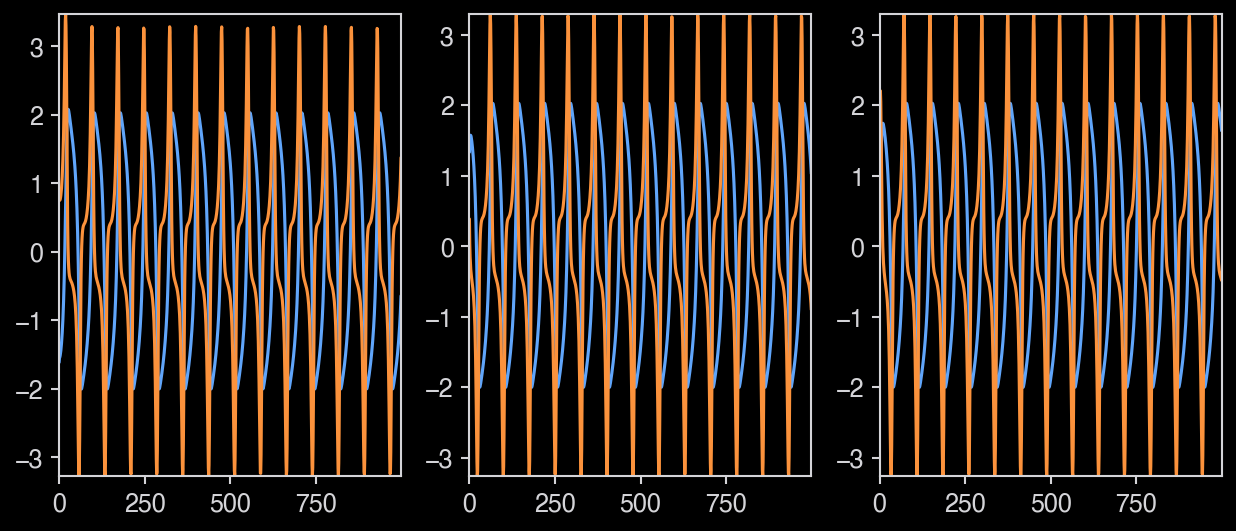

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for k, ax in enumerate(axs):
    ax.plot(yhat[k][:1000])

In [66]:
states.shape

(320, 1000, 256)

In [75]:
sampled_states = np.vstack(states[:, ::100])
print(sampled_states.shape)

(3200, 256)


## PCA

In [76]:
from sklearn.decomposition import PCA

In [80]:
pca = PCA(n_components=256).fit(sampled_states)

<Axes: >

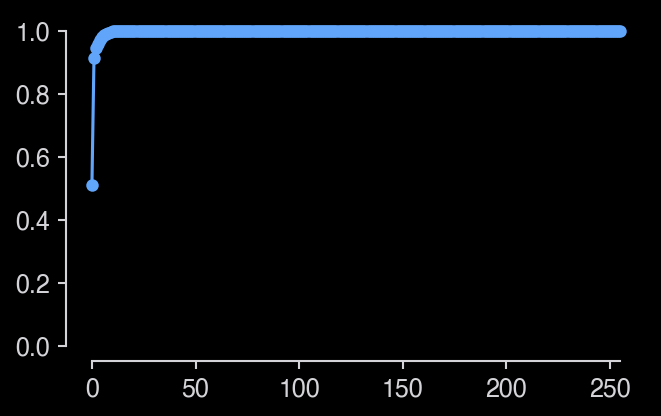

In [88]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.ylim(0, 1)
jp.breathe()

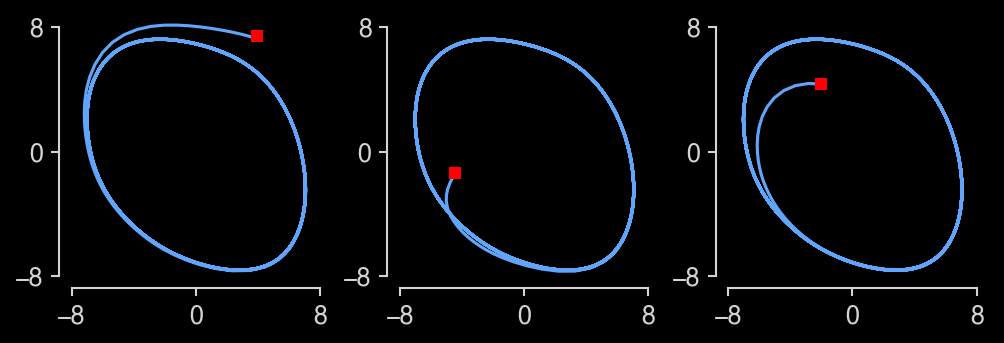

In [102]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3))

for k, ax in enumerate(axs):
    hx, hy = pca.transform(states[k])[:, :2].T
    ax.plot(hx, hy, '-')
    ax.plot(hx[0], hy[0], 'rs')
    ax.set_xlim(-8, 8)
    ax.set_ylim(-8, 8)
    ax.set_xticks([-8, 0, 8])
    ax.set_yticks([-8, 0, 8])
    ax.set_aspect("equal")
    jp.breathe(ax=ax)

## Set up Reverse Engineering problem

In [103]:
import torch

In [104]:
BZ = 32
INPUT_DIM = 2

inputs = torch.zeros((BZ, INPUT_DIM))

In [105]:
from tqdm.notebook import trange
import numpy as np

In [106]:
def build_loss_fun(model, h0):
    
    h = torch.nn.Parameter(data=h0)
    bz = h0.shape[1]
    
    inputs = torch.zeros((bz, 1, 1))
    
    def loss_fun():
        _, h_next = model.gru(inputs, h)
        delta = torch.norm((h_next - h).squeeze(), dim=0)
        loss = torch.mean(delta)
        return loss

    return loss_fun, [h,]


def optimize(loss_fun, params, max_iter=10000, lr=2e-3):
    optimizer = torch.optim.Adam(params, lr=lr)
    loss_hist = []

    for k in trange(max_iter):
        loss = loss_fun()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist.append(loss.detach().numpy())

    return np.array(loss_hist)

In [110]:
h0 = torch.randn((1, 32, 256))
loss_fun, params = build_loss_fun(model, h0)

In [111]:
loss_hist = optimize(loss_fun, params, max_iter=20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

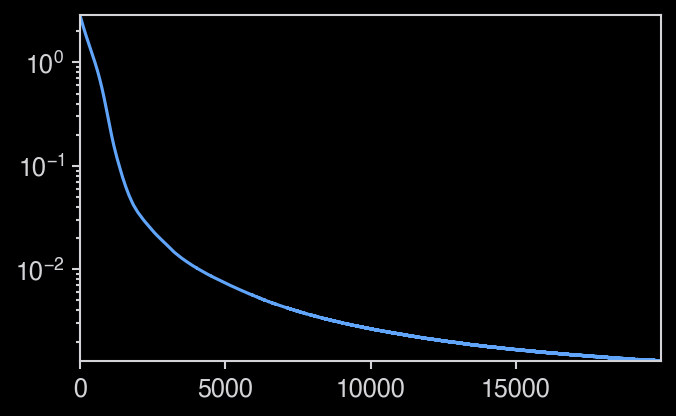

In [112]:
plt.semilogy(loss_hist)

In [113]:
h_star = params[0].detach().numpy().squeeze()

In [114]:
h_star.shape

(32, 256)

In [117]:
xstar, ystar = pca.transform(h_star)[:, :2].T

<Axes: >

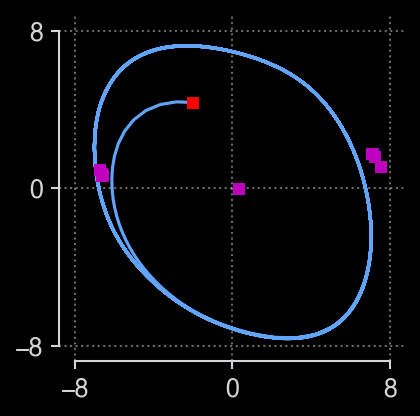

In [126]:
fig, ax = plt.subplots()

ax.set_aspect("equal")
ax.plot(hx, hy, '-')
ax.plot(hx[0], hy[0], 'rs')
ax.set_xlim(-8, 8)
ax.set_xticks([-8, 0, 8])
ax.set_ylim(-8, 8)
ax.set_yticks([-8, 0, 8])
ax.grid()

ax.plot(xstar, ystar, 'ms')

jp.breathe(ax=ax)

In [154]:
h_star.shape

(32, 256)

In [157]:
_, h_next = model.gru(torch.zeros((32, 1, 1)), torch.from_numpy(h_star).float().reshape((1, 32, 256)) )

In [161]:
h_prev = h_next.squeeze().detach().numpy()

In [172]:
err = np.linalg.norm((h_prev - h_star), axis=1)
inds = np.arange(32)

<Axes: >

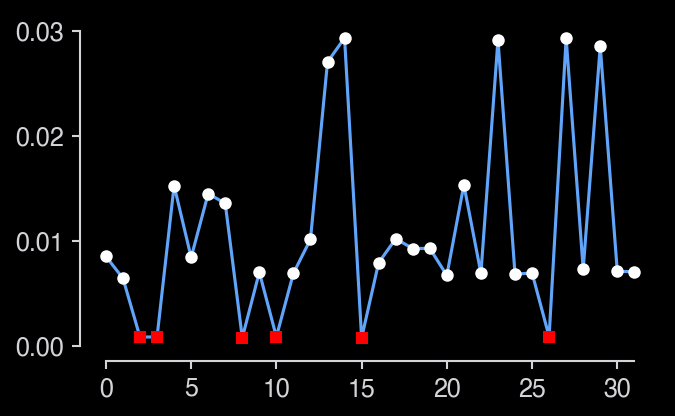

In [176]:
plt.plot(inds, err, '-')
plt.plot(inds[mask], err[mask], 'rs')
plt.plot(inds[~mask], err[~mask], 'wo')
plt.ylim(0.0, 0.03)
jp.breathe()

In [149]:
mask = (np.abs(xstar) < 0.5) & (np.abs(ystar) < 0.5)
inds = np.where(mask)[0]

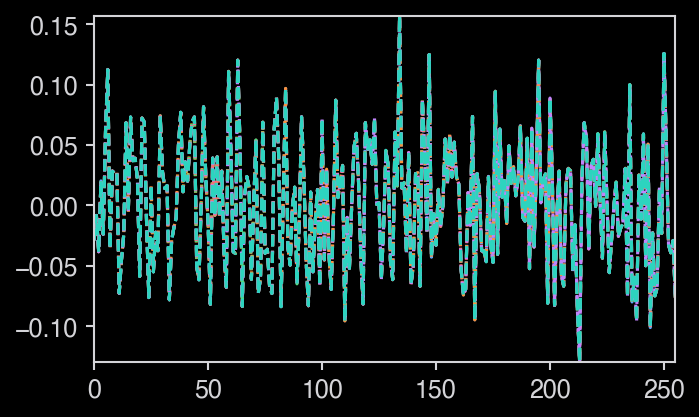

In [151]:
plt.plot(h_star[mask].T, '--')
# plt.plot(h_star[~mask].T, ':')

In [177]:
fixed_point = h_star[mask].mean(axis=0)
print(fixed_point.shape)

(256,)


In [181]:
def F(x, h):
    _x = x.reshape((1, 1, 1))
    _h = h.reshape((1, 1, 256))
    _, _h_next = model.gru(_x, _h)
    return _h_next

In [187]:
Jx, Jh = torch.autograd.functional.jacobian(F, (torch.zeros(1), torch.from_numpy(fixed_point).float()))

Jx = Jx.squeeze().detach().numpy()
Jh = Jh.squeeze().detach().numpy()

In [191]:
Jx.shape

(256,)

In [192]:
U, V = np.linalg.eig(Jh)

<Axes: >

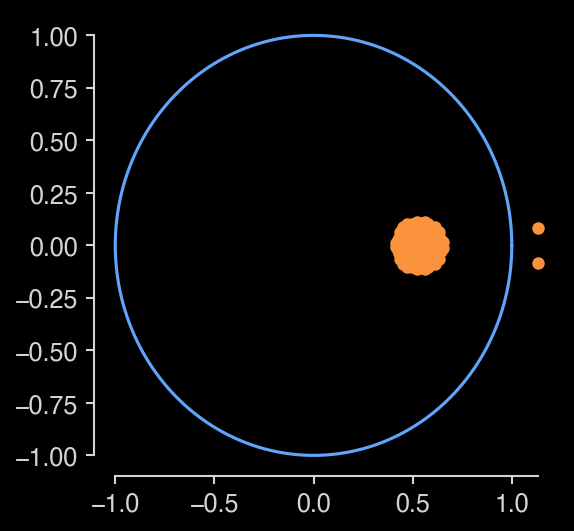

In [203]:
fig, ax = plt.subplots(figsize=(4, 4))
jp.circle(ax=ax)
ax.plot(np.real(U), np.imag(U), 'o')
jp.breathe(ax=ax)

In [218]:
1 / np.log(np.abs(U[0]))

np.float32(7.8823595)

In [208]:
f = build_loss_fun(model, h0s)

In [218]:
x = torch.nn.Parameter(data=torch.randn(10))
y = torch.from_numpy(np.arange(10).astype('float')).float()

In [219]:

def loss_fun():
    loss = torch.norm(x - y)
    # loss_hist.append(loss.detach().numpy())
    return loss

In [220]:
from tqdm.notebook import trange

In [221]:
params = [x,]
optimizer = torch.optim.SGD(params, lr=0.05)
loss_hist = []

for k in trange(1000):
    loss = loss_fun()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist.append(loss.detach().numpy())

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: >

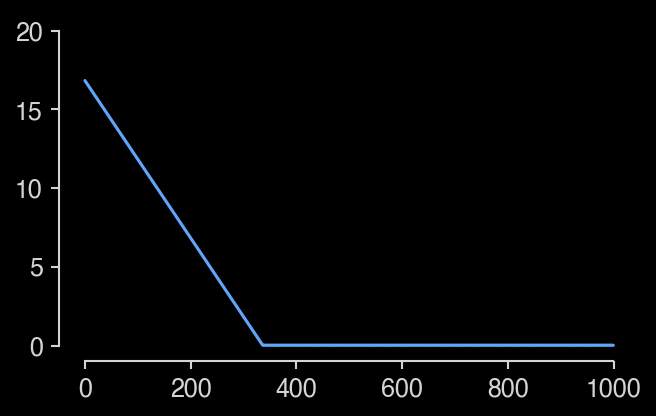

In [224]:
plt.plot(np.array(loss_hist))
plt.ylim(0, 20)
jp.breathe()

In [140]:
torch.mean(torch.norm( (h_final - h0s).squeeze(), dim=0))

tensor(6.4827, grad_fn=<MeanBackward0>)

In [118]:
_, h_final = model.gru(inputs, h0s)

In [127]:
h_next.shape

torch.Size([32, 1, 256])

In [128]:
h_final.shape

torch.Size([1, 32, 256])

In [129]:
h0s.shape

torch.Size([1, 32, 256])

In [119]:
h_next.shape

torch.Size([32, 1, 256])

In [120]:
h_final.shape

torch.Size([1, 32, 256])

In [122]:
ha = h_next.squeeze().detach().numpy()

In [123]:
hb = h_final.squeeze().detach().numpy()

In [125]:
import numpy as np

In [126]:
np.allclose(ha, hb)

True